In [1]:
#pip install --upgrade openpyxl
#!pip install lifetimes

In [34]:
import pandas as pd
import numpy as np
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

In [3]:
df = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')
rows = df.shape[0]
print("Total Rows:", rows)
df.head()

Total Rows: 541910


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 1. Data Preparation

In [4]:
df = df.drop('Description', axis=1)

In [5]:
df = df[~df["Invoice"].astype(str).str.startswith("C")]
print(rows - df.shape[0], "rows removed!")
rows = df.shape[0]

9288 rows removed!


In [6]:
df = df[
    (df["Quantity"] > 0) &
    (df["Price"] > 0)
]
print(rows - df.shape[0], "rows removed!")
rows = df.shape[0]

2517 rows removed!


In [7]:
df = df.dropna(subset=["Customer ID"])
print(rows - df.shape[0], "rows removed!")
print("Total Rows:", df.shape[0])

132220 rows removed!
Total Rows: 397885


In [8]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [9]:
invoice_df = (
    df
    .groupby(["Customer ID", "Invoice", "InvoiceDate"], as_index=False)
    .agg({"TotalPrice": "sum"})
)
invoice_df.head()

,Customer ID,Invoice,InvoiceDate,TotalPrice
0,12346.0,541431,2011-01-18 10:01:00,77183.60
1,12347.0,537626,2010-12-07 14:57:00,711.79
2,12347.0,542237,2011-01-26 14:30:00,475.39
3,12347.0,549222,2011-04-07 10:43:00,636.25
4,12347.0,556201,2011-06-09 13:01:00,382.52


In [10]:
analysis_date = invoice_df["InvoiceDate"].max() + pd.Timedelta(days=1)

In [11]:
clv_summary = summary_data_from_transaction_data(
    invoice_df,
    customer_id_col="Customer ID",
    datetime_col="InvoiceDate",
    monetary_value_col="TotalPrice",
    observation_period_end=analysis_date
)

clv_summary.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,0.0,0.0,326.0,0.000000
12347.0,6.0,365.0,368.0,599.701667
12348.0,3.0,283.0,359.0,301.480000
12349.0,0.0,0.0,19.0,0.000000
12350.0,0.0,0.0,311.0,0.000000


In [12]:
clv_summary = clv_summary[
    (clv_summary["frequency"] > 0) &
    (clv_summary["monetary_value"] > 0)
]
clv_summary.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12347.0,6.0,365.0,368.0,599.701667
12348.0,3.0,283.0,359.0,301.480000
12352.0,6.0,260.0,297.0,368.256667
12356.0,2.0,303.0,326.0,269.905000
12358.0,1.0,149.0,151.0,683.200000


### 2. BG/NBD

In [13]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(
    clv_summary["frequency"],
    clv_summary["recency"],
    clv_summary["T"]
)

<lifetimes.BetaGeoFitter: fitted with 2790 subjects, a: 0.01, alpha: 106.53, b: 0.17, r: 1.89>

In [14]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.893004,0.067851,1.760017,2.025991
alpha,106.525241,4.237304,98.220125,114.830357
a,0.009203,0.004463,0.000454,0.017951
b,0.165842,0.083930,0.001339,0.330344


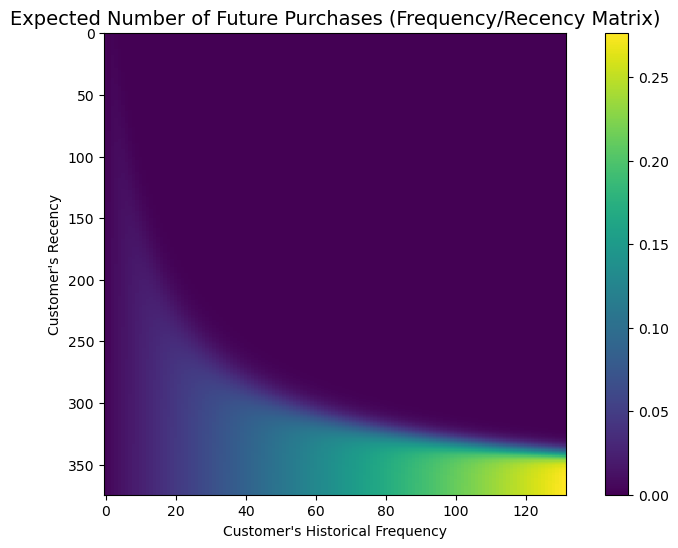

In [37]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_frequency_recency_matrix(bgf)
plt.title("Expected Number of Future Purchases (Frequency/Recency Matrix)", fontsize=14)
plt.show()

In [15]:
clv_summary["prob_alive"] = bgf.conditional_probability_alive(
    clv_summary["frequency"],
    clv_summary["recency"],
    clv_summary["T"]
)

In [16]:
clv_summary["pred_purchases_6m"] = bgf.predict(
    6 * 30,   # حدوداً 6 ماه
    clv_summary["frequency"],
    clv_summary["recency"],
    clv_summary["T"]
)
clv_summary.head()

,frequency,recency,T,monetary_value,prob_alive,pred_purchases_6m
Customer ID,,,,,,
12347.0,6.0,365.0,368.0,599.701667,0.998131,2.981978
12348.0,3.0,283.0,359.0,301.480000,0.989939,1.867741
12352.0,6.0,260.0,297.0,368.256667,0.996209,3.498773
12356.0,2.0,303.0,326.0,269.905000,0.990330,1.598882
12358.0,1.0,149.0,151.0,683.200000,0.946291,1.899717


### 3. Gamma-Gamma

In [17]:
clv_summary[["frequency", "monetary_value"]].corr()

,frequency,monetary_value
frequency,1.000000,0.015905
monetary_value,0.015905,1.000000


In [18]:
ggf = GammaGammaFitter(penalizer_coef=0.001)

ggf.fit(
    clv_summary["frequency"],
    clv_summary["monetary_value"]
)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 11.13, q: 0.84, v: 11.29>

In [19]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,11.125602,0.269274,10.597825,11.653379
q,0.838780,0.019731,0.800107,0.877452
v,11.293018,0.281539,10.741201,11.844836


In [20]:
clv_summary["expected_avg_order_value"] = (
    ggf.conditional_expected_average_profit(
        clv_summary["frequency"],
        clv_summary["monetary_value"]
    )
)
clv_summary.head()

,frequency,recency,T,monetary_value,prob_alive,pred_purchases_6m,expected_avg_order_value
Customer ID,,,,,,,
12347.0,6.0,365.0,368.0,599.701667,0.998131,2.981978,603.040271
12348.0,3.0,283.0,359.0,301.480000,0.989939,1.867741,306.725919
12352.0,6.0,260.0,297.0,368.256667,0.996209,3.498773,371.034942
12356.0,2.0,303.0,326.0,269.905000,0.990330,1.598882,277.562577
12358.0,1.0,149.0,151.0,683.200000,0.946291,1.899717,704.704836


In [21]:
clv_summary["clv_6m"] = ggf.customer_lifetime_value(
    bgf,
    clv_summary["frequency"],
    clv_summary["recency"],
    clv_summary["T"],
    clv_summary["monetary_value"],
    time=6,          # ماه
    discount_rate=0.01
)


In [39]:
top_customers = clv_summary.sort_values(by='clv_6m', ascending=False).head(10)
top_customers[['clv_6m', 'expected_avg_order_value', 'pred_purchases_6m']]

,clv_6m,expected_avg_order_value,pred_purchases_6m
Customer ID,,,
16446.0,258934.450919,170958.234188,1.567976
14646.0,109900.173011,6369.060148,17.863990
18102.0,91989.900558,9355.351625,10.179709
17450.0,75546.982677,7409.254226,10.555966
14096.0,60534.450795,4075.831597,15.375710
14911.0,52508.865749,1093.868887,49.696206
12415.0,51801.607748,7868.564381,6.815572
14156.0,44370.361786,2788.312577,16.474306
17511.0,34502.371823,3307.254006,10.800326


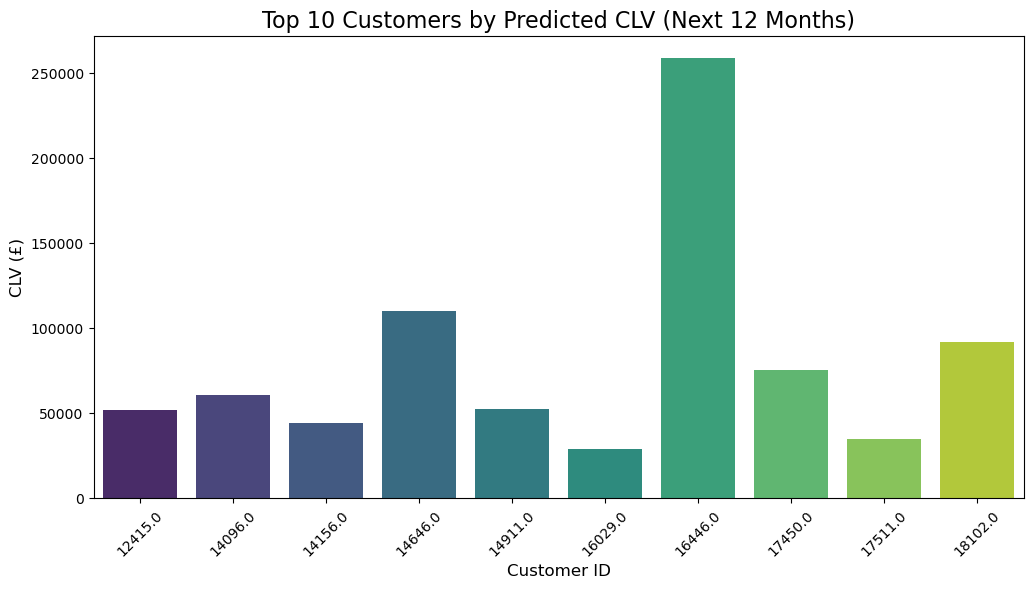

In [ ]:
#VIP Customer Visualization
import seaborn as sns

plt.figure(figsize=(12, 6))
# 
sns.barplot(x=top_customers.index, y=top_customers['clv_6m'], palette="viridis")

plt.title('Top 10 Customers by Predicted CLV (Next 6 Months)', fontsize=16)
plt.xlabel('Customer ID', fontsize=12)
plt.ylabel('CLV (£)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### 4. Validation

In [23]:
train_end_date = "2010-12-31"

train_data = invoice_df[invoice_df["InvoiceDate"] <= train_end_date]
test_data  = invoice_df[invoice_df["InvoiceDate"] > train_end_date]


In [24]:
summary_train = summary_data_from_transaction_data(
    train_data,
    customer_id_col="Customer ID",
    datetime_col="InvoiceDate",
    monetary_value_col="TotalPrice",
    observation_period_end=pd.to_datetime(train_end_date)
)


In [25]:
# Fit BG/NBD model on training data
t_holdout = 6 * 30

summary_train["pred_purchases_holdout"] = bgf.predict(
    t_holdout,
    summary_train["frequency"],
    summary_train["recency"],
    summary_train["T"]
)


C:\Users\MSI-Laptop\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
# Calculate actual purchases in the holdout period
actual_purchases = (
    test_data
    .groupby("Customer ID")
    .size()
    .rename("actual_purchases_holdout")
)   



In [28]:
# Create validation dataframe
validation_df = summary_train.join(actual_purchases, how="left")
validation_df["actual_purchases_holdout"] = validation_df["actual_purchases_holdout"].fillna(0)


In [29]:
validation_df[["pred_purchases_holdout", "actual_purchases_holdout"]].sum()

pred_purchases_holdout       922.670699
actual_purchases_holdout    6931.000000
dtype: float64

In [30]:
validation_df["pred_rank"] = validation_df["pred_purchases_holdout"].rank(ascending=False)
validation_df["actual_rank"] = validation_df["actual_purchases_holdout"].rank(ascending=False)

validation_df[["pred_rank", "actual_rank"]].corr(method="spearman")


,pred_rank,actual_rank
pred_rank,1.000000,0.323165
actual_rank,0.323165,1.000000


### 5. Business Insights

In [31]:
# Segment customers based on CLV
clv_summary["clv_segment"] = pd.qcut(
    clv_summary["clv_6m"],
    q=4,
    labels=["Low", "Mid-Low", "Mid-High", "High"]
)


In [32]:
# Calculate CLV distribution across segments
clv_distribution = (
    clv_summary
    .groupby("clv_segment")["clv_6m"]
    .sum()
    .reset_index()
)


In [35]:
clv_summary["strategy_flag"] = np.where(
    (clv_summary["clv_6m"] > clv_summary["clv_6m"].quantile(0.75)) &
    (clv_summary["prob_alive"] > 0.5),
    "Core Customers",
    "Others"
)
clv_summary.head()

,frequency,recency,T,monetary_value,prob_alive,pred_purchases_6m,expected_avg_order_value,clv_6m,clv_segment,strategy_flag
Customer ID,,,,,,,,,,
12347.0,6.0,365.0,368.0,599.701667,0.998131,2.981978,603.040271,1736.989095,High,Core Customers
12348.0,3.0,283.0,359.0,301.480000,0.989939,1.867741,306.725919,553.370081,Mid-Low,Others
12352.0,6.0,260.0,297.0,368.256667,0.996209,3.498773,371.034942,1253.943759,Mid-High,Others
12356.0,2.0,303.0,326.0,269.905000,0.990330,1.598882,277.562577,428.675211,Mid-Low,Others
12358.0,1.0,149.0,151.0,683.200000,0.946291,1.899717,704.704836,1293.180753,Mid-High,Others


In [36]:
clv_summary['strategy_flag'].value_counts()

strategy_flag
Others            2092
Core Customers     698
Name: count, dtype: int64